
<center>
  <h1>Graph Machine Learning Project</h1>
  <h2>CentraleSupélec</h2>
  <h3>Alae Taoudi - Mohammed Sbaihi - Ouissal Boutouatou</h3>
</center>

<span style="color:red">N.B: In today's session (16/01/2026) we decided to change the choice of dataset to the Cora dataset. Thus we had to redo the analytics part. And consequently we didn't have the time to do the GNN. We continue to work on the project but today's delivered notebook will not cover GNN.</span><br>

We choose to work on the Cora dataset, which is a co-citation network of scientific publications. Each node represents a publication, the presence of an edge between two nodes indicates that the two papers are co-cited by other papers. The dataset contains 2708 scientific publications (nodes) and 5278 edges (undirected). We plan to use this graph on the link level task of predicting whether two papers are likely to be co-cited based on their content and the structure of the graph (link prediction task). Each node contain textual information (title and abstract of the paper) that we will encode using a pre-trained language model (RoBERTa) to obtain meaningful vector representations (embeddings) of size 1024. These embeddings will be used as features to create node representations that capture both the textual content and the graph structure. <br>

Also note that each publication belongs to one of seven classes. But in this project, we will focus on the link prediction task rather than node classification.

## 1. Loading the graph dataset

In [ ]:
import torch
import torch_geometric as pyg
from torch_geometric.datasets import Planetoid

path = "data/cora.pt"
data = torch.load(path, weights_only=False)
text = data.raw_text

# we don't need label names for now
label_names = data.label_names

# nodes already have features (tensors), we should create new node features using raw_text
print(f"Number of features per node : {data.num_node_features}")

# let's see the first node's text
print(f"Node 0 text : {text[0]}")


Numbef of nodes : 2708
Number of edges : 10858
Number of features per node : 384
Node 0 text :  Stochastic pro-positionalization of non-determinate background knowledge. : It is a well-known fact that propositional learning algorithms require "good" features to perform well in practice. So a major step in data engineering for inductive learning is the construction of good features by domain experts. These features often represent properties of structured objects, where a property typically is the occurrence of a certain substructure having certain properties. To partly automate the process of "feature engineering", we devised an algorithm that searches for features which are defined by such substructures. The algorithm stochastically conducts a top-down search for first-order clauses, where each clause represents a binary feature. It differs from existing algorithms in that its search is not class-blind, and that it is capable of considering clauses ("context") of almost arbitrary leng

## 2. Graph Analytics

### 2.1 Basic Graph Statistics

In [95]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from collections import Counter
from torch_geometric.utils import to_networkx
import warnings
warnings.filterwarnings('ignore')

# -- style config
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [96]:
# -- convert PyTorch Geometric data to NetworkX graph for analysis
# -- make a copy to avoid modifying the original data
data_copy = data.clone()
G = to_networkx(data_copy, to_undirected=True)
print(f"Graph converted to NetworkX: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

Graph converted to NetworkX: 2708 nodes, 5278 edges


In [97]:
# -- compute basic statistics
stats = {
    'graph_name': 'Cora Co-citation Network',
    'num_nodes': G.number_of_nodes(),
    'num_edges': G.number_of_edges(),
    'density': nx.density(G),
    'is_connected': nx.is_connected(G),
    'num_components': nx.number_connected_components(G)
}

# -- check if graph is directed or undirected
print("=== Basic Graph Properties ===")
print(f"Graph type: {'Undirected' if isinstance(G, nx.Graph) else 'Directed'}")
print(f"Number of nodes: {stats['num_nodes']}")
print(f"Number of edges: {stats['num_edges']}")
print(f"Graph density: {stats['density']:.6f}")
print(f"Is connected: {stats['is_connected']}")
print(f"Number of connected components: {stats['num_components']}")

if stats['is_connected']:
    diameter = nx.diameter(G)
    avg_path_length = nx.average_shortest_path_length(G)
    print(f"Graph diameter: {diameter}")
    print(f"Average shortest path length: {avg_path_length:.3f}")
else:
    # -- analyze largest component
    largest_cc = max(nx.connected_components(G), key=len)
    G_largest = G.subgraph(largest_cc).copy()
    diameter = nx.diameter(G_largest)
    avg_path_length = nx.average_shortest_path_length(G_largest)
    print(f"\nLargest component has {len(largest_cc)} nodes")
    print(f"Diameter (largest component): {diameter}")
    print(f"Average shortest path length (largest component): {avg_path_length:.3f}")

=== Basic Graph Properties ===
Graph type: Undirected
Number of nodes: 2708
Number of edges: 5278
Graph density: 0.001440
Is connected: False
Number of connected components: 78

Largest component has 2485 nodes
Diameter (largest component): 19
Average shortest path length (largest component): 6.311



Degree Statistics:
Average degree: 3.90
Median degree: 3
Min degree: 1
Max degree: 168
Std deviation: 5.23


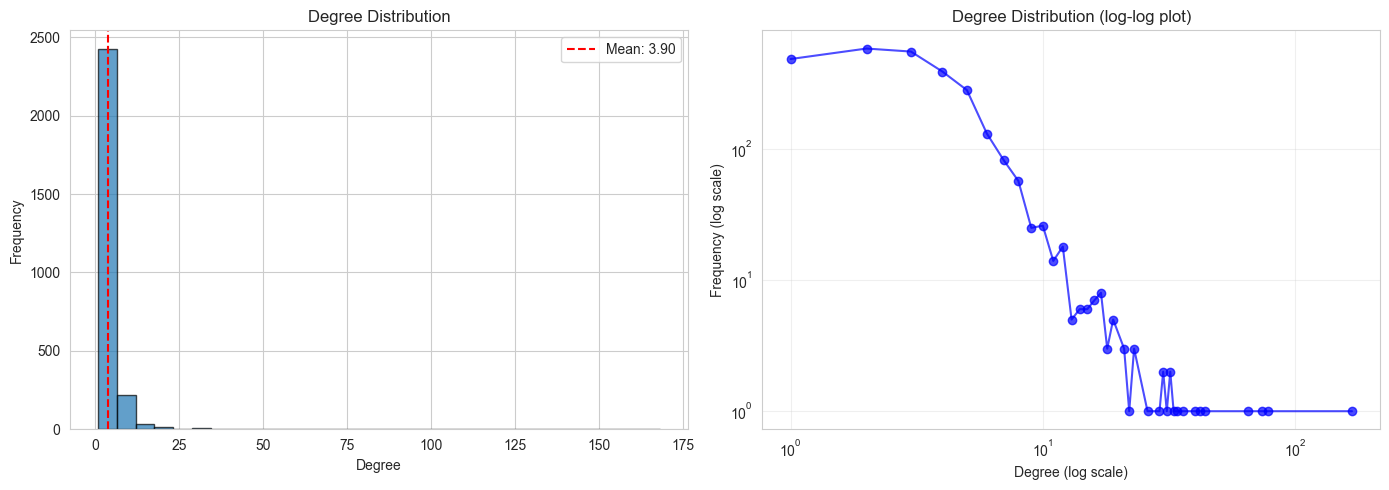

In [98]:
# -- degree distribution
degrees = dict(G.degree())
degree_values = list(degrees.values())
degree_dist = Counter(degree_values)

print(f"\nDegree Statistics:")
print(f"Average degree: {np.mean(degree_values):.2f}")
print(f"Median degree: {np.median(degree_values):.0f}")
print(f"Min degree: {min(degree_values)}")
print(f"Max degree: {max(degree_values)}")
print(f"Std deviation: {np.std(degree_values):.2f}")

# -- plot degree distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# -- histogram
axes[0].hist(degree_values, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Degree Distribution')
axes[0].axvline(np.mean(degree_values), color='red', linestyle='--', label=f'Mean: {np.mean(degree_values):.2f}')
axes[0].legend()

# -- log-log plot to check for power law
degree_counts = sorted(degree_dist.items())
degrees_x = [d[0] for d in degree_counts]
counts_y = [d[1] for d in degree_counts]
axes[1].loglog(degrees_x, counts_y, 'bo-', alpha=0.7)
axes[1].set_xlabel('Degree (log scale)')
axes[1].set_ylabel('Frequency (log scale)')
axes[1].set_title('Degree Distribution (log-log plot)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 2.2 Centrality Measures Analysis

#### 2.2.1 Degree Centrality

In [99]:
# -- degree centrality
degree_cent = nx.degree_centrality(G)
print("Top 10 nodes by Degree Centrality:")
for node, cent in sorted(degree_cent.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"  Node {node}: {cent:.4f} (degree: {G.degree(node)})")

Top 10 nodes by Degree Centrality:
  Node 1686: 0.0621 (degree: 168)
  Node 2177: 0.0288 (degree: 78)
  Node 1016: 0.0273 (degree: 74)
  Node 1634: 0.0240 (degree: 65)
  Node 2628: 0.0163 (degree: 44)
  Node 753: 0.0155 (degree: 42)
  Node 1834: 0.0148 (degree: 40)
  Node 1635: 0.0133 (degree: 36)
  Node 962: 0.0126 (degree: 34)
  Node 1270: 0.0122 (degree: 33)


#### 2.2.2 Eigenvector Centrality

In [100]:
# -- eigenvector centrality
try:
    eigenvector_cent = nx.eigenvector_centrality(G, max_iter=1000)
    print("Top 10 nodes by Eigenvector Centrality:")
    for node, cent in sorted(eigenvector_cent.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"  Node {node}: {cent:.4f}")
except:
    print("Eigenvector centrality computation failed (graph may not be connected)")
    eigenvector_cent = None

Top 10 nodes by Eigenvector Centrality:
  Node 1686: 0.6543
  Node 2563: 0.1179
  Node 2583: 0.0992
  Node 1316: 0.0918
  Node 2611: 0.0914
  Node 1153: 0.0903
  Node 949: 0.0871
  Node 1548: 0.0855
  Node 2571: 0.0770
  Node 1690: 0.0748


#### 2.2.3 PageRank Centrality

In [101]:
# -- PageRank centrality
pagerank_cent = nx.pagerank(G, alpha=0.85)
print("Top 10 nodes by PageRank:")
for node, cent in sorted(pagerank_cent.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"  Node {node}: {cent:.4f}")

Top 10 nodes by PageRank:
  Node 1686: 0.0122
  Node 1016: 0.0063
  Node 1634: 0.0054
  Node 2177: 0.0051
  Node 2628: 0.0036
  Node 1834: 0.0032
  Node 753: 0.0028
  Node 1635: 0.0027
  Node 1270: 0.0026
  Node 962: 0.0025


#### 2.2.4 Betweenness Centrality

In [102]:
# -- betweenness centrality
betweenness_cent = nx.betweenness_centrality(G)
print("Top 10 nodes by Betweenness Centrality:")
for node, cent in sorted(betweenness_cent.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"  Node {node}: {cent:.4f}")

Top 10 nodes by Betweenness Centrality:
  Node 1686: 0.2325
  Node 1634: 0.1261
  Node 1834: 0.0893
  Node 1016: 0.0853
  Node 2177: 0.0764
  Node 2611: 0.0679
  Node 962: 0.0632
  Node 2628: 0.0525
  Node 1635: 0.0498
  Node 2178: 0.0413


#### 2.2.5 Closeness Centrality

In [ ]:
# -- closeness centrality
if nx.is_connected(G):
    closeness_cent = nx.closeness_centrality(G)
    print("Top 10 nodes by Closeness Centrality:")
    for node, cent in sorted(closeness_cent.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"  Node {node}: {cent:.4f}")
else:
    print("Graph is not connected, computing closeness on largest component")
    largest_cc = max(nx.connected_components(G), key=len)
    G_cc = G.subgraph(largest_cc).copy()
    closeness_cent = nx.closeness_centrality(G_cc)
    print(f"\nTop 10 nodes by Closeness Centrality (largest component with {len(largest_cc)} nodes):")
    for node, cent in sorted(closeness_cent.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"  Node {node}: {cent:.4f}")

Graph is not connected, computing closeness on largest component

Top 10 nodes by Closeness Centrality (largest component with 2485 nodes):
  Node 1686: 0.2428
  Node 2177: 0.2410
  Node 1634: 0.2396
  Node 2611: 0.2354
  Node 1864: 0.2353
  Node 2178: 0.2325
  Node 962: 0.2315
  Node 2173: 0.2276
  Node 1834: 0.2263
  Node 41: 0.2260


#### 2.2.6 Clustering Coefficient

In [104]:
# -- clustering coefficients
clustering_coef = nx.clustering(G)
avg_clustering = nx.average_clustering(G)

print(f"Average Clustering Coefficient: {avg_clustering:.4f}")
print("\nTop 10 nodes by Clustering Coefficient:")
for node, coef in sorted(clustering_coef.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"  Node {node}: {coef:.4f}")

Average Clustering Coefficient: 0.2407

Top 10 nodes by Clustering Coefficient:
  Node 21: 1.0000
  Node 24: 1.0000
  Node 46: 1.0000
  Node 50: 1.0000
  Node 63: 1.0000
  Node 70: 1.0000
  Node 76: 1.0000
  Node 89: 1.0000
  Node 90: 1.0000
  Node 98: 1.0000


#### 2.2.7 Compare Centrality Measures

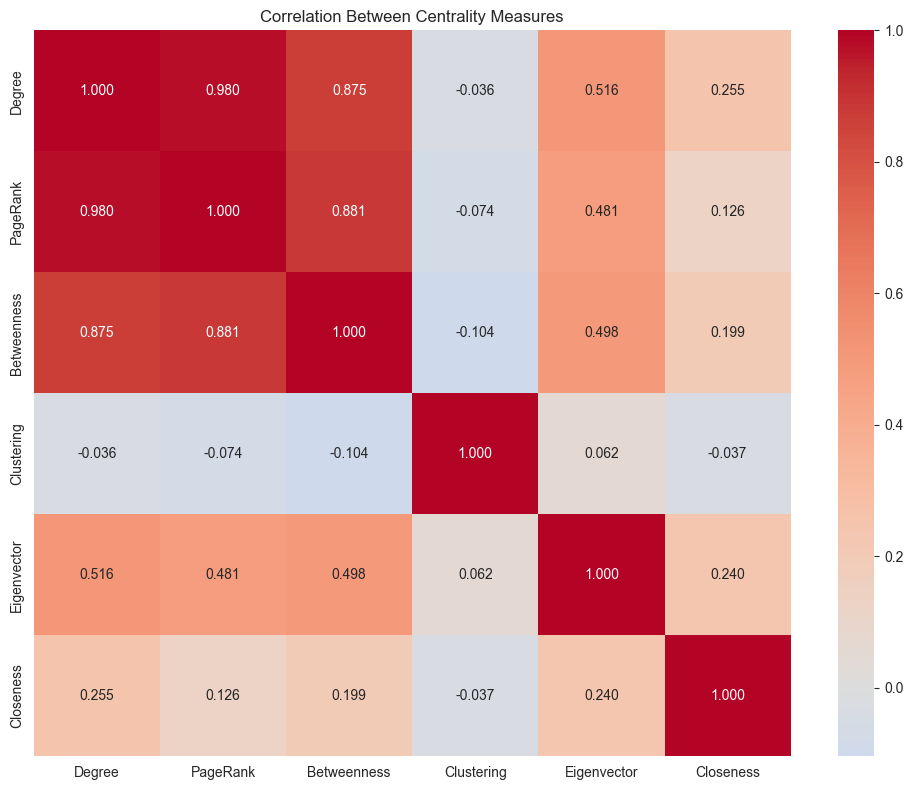

In [105]:
# -- dataframe with all centrality measures
centrality_df = pd.DataFrame({
    'Degree': degree_cent,
    'PageRank': pagerank_cent,
    'Betweenness': betweenness_cent,
    'Clustering': clustering_coef
})

if eigenvector_cent:
    centrality_df['Eigenvector'] = pd.Series(eigenvector_cent)

if not nx.is_connected(G):
    # -- for closeness, fill missing values with 0
    closeness_full = {node: 0 for node in G.nodes()}
    closeness_full.update(closeness_cent)
    centrality_df['Closeness'] = pd.Series(closeness_full)
else:
    centrality_df['Closeness'] = pd.Series(closeness_cent)

# -- correlation between centrality measures
plt.figure(figsize=(10, 8))
sns.heatmap(centrality_df.corr(), annot=True, cmap='coolwarm', center=0, fmt='.3f')
plt.title('Correlation Between Centrality Measures')
plt.tight_layout()
plt.show()

## 3. Node Embeddings

## 3.1 Text Embeddings

### 3.1.1 Enocding nodes texts using RoBERTa
We use the RoBERTa model to encode the nodes texts to embeddings of size 1024. We will use the HuggingFace Inference API to encode the texts in batches without having to load and run the model locally. This requires an HF token. You can generate one for free on your HuggingFace account. We ran the encoding using a PRO account to benefit from higher rate limits. But the free account should be sufficient for encoding the Cora dataset.

In [78]:
import os

# -- load HF token to use inference client instead of running the model locally
from dotenv import load_dotenv
load_dotenv()
hf_token = os.getenv("HF_TOKEN")

In [80]:
# we have 2708 nodes, we need to batch the encoding to avoid memory issues
from huggingface_hub import InferenceClient
from tqdm import tqdm
import torch

MODEL_NAME = "sentence-transformers/all-roberta-large-v1"
BATCH_SIZE = 64

client = InferenceClient(
    provider="hf-inference",
    api_key=hf_token,
)


def batch_encode(texts, model, batch_size=64):
    """
    Encode a list of texts using a sentence transformer model via HuggingFace Inference API.
    
    Args:
        texts: List of strings (title and abstract of papers) to encode
        model: Name of the model to use
        batch_size: Number of texts to encode in each batch
    
    Returns:
        torch.Tensor: Embeddings tensor of shape (len(texts), embedding_dim)
    """
    embeddings = []
    num_batches = (len(texts) + batch_size - 1) // batch_size  # ceiling division
    
    for i in tqdm(range(0, len(texts), batch_size), 
                  desc="Encoding batches", 
                  total=num_batches):
        batch_texts = texts[i:i+batch_size]
        batch_embeddings = client.feature_extraction(
            text=batch_texts,
            model=model,
        ) # returns a list of arrays
        batch_embeddings = torch.tensor(batch_embeddings)
        embeddings.append(batch_embeddings)
    
    return torch.cat(embeddings, dim=0)


embeddings = batch_encode(text, MODEL_NAME, BATCH_SIZE)
print(f"Embeddings shape: {embeddings.shape}")

Encoding batches: 100%|██████████| 43/43 [07:00<00:00,  9.78s/it]

Embeddings shape: torch.Size([2708, 1024])


In [81]:
# -- let's save the embeddings
torch.save(embeddings, "data/cora_embeddings.pt")

# -- we can also replace the existing node features with the new embeddings
data.x = embeddings

### 3.1.2 Text Embedding Quality Analysis
Before using the embeddings to generate node representations, we want to make sure that the embeddings capture the semantic similarity between the papers. We can do this by visualizing the embeddings in 2D space using t-SNE and coloring the points based on their classes. If the embeddings are good, we should see that papers from the same class are clustered together (assuming the classes are semantically meaningful).

Note that we only use the classes for visualization purposes, not for training or evaluation.

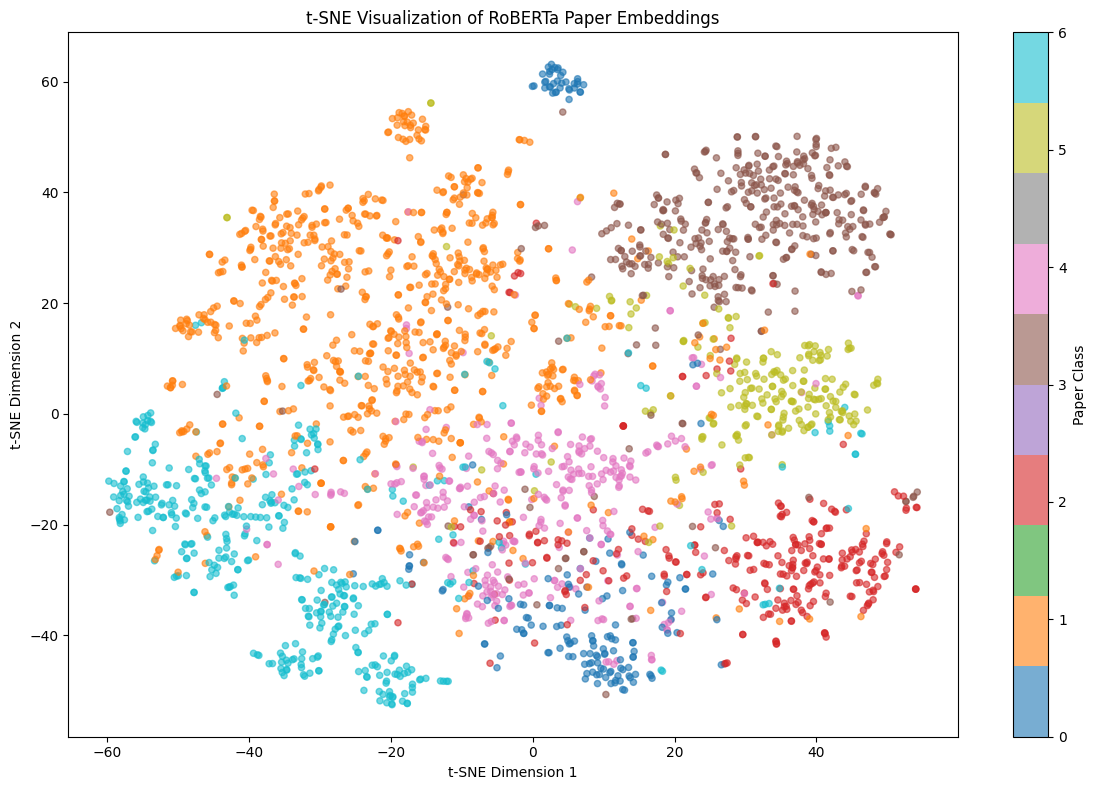

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# -- reduce embeddings to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings.numpy())

# -- color by class labels
plt.figure(figsize=(12, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                     c=data.y.numpy(), cmap='tab10', alpha=0.6, s=20)
plt.colorbar(scatter, label='Paper Class')
plt.title('t-SNE Visualization of RoBERTa Paper Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.tight_layout()
plt.show()

### 3.1.3 Graph-Content Correlation Analysis
Once we confirmed that the text embeddings are of good quality, we naturally want to check if there is a correlation between the graph structure and the content of the papers. In other words, do papers that are connected in the graph (co-cited) have similar content (embeddings)? To do so, we measure the similarity between the embeddings of connected nodes and compare it to the similarity between non-connected nodes. We can use cosine similarity as a measure of similarity between normalized embeddings.

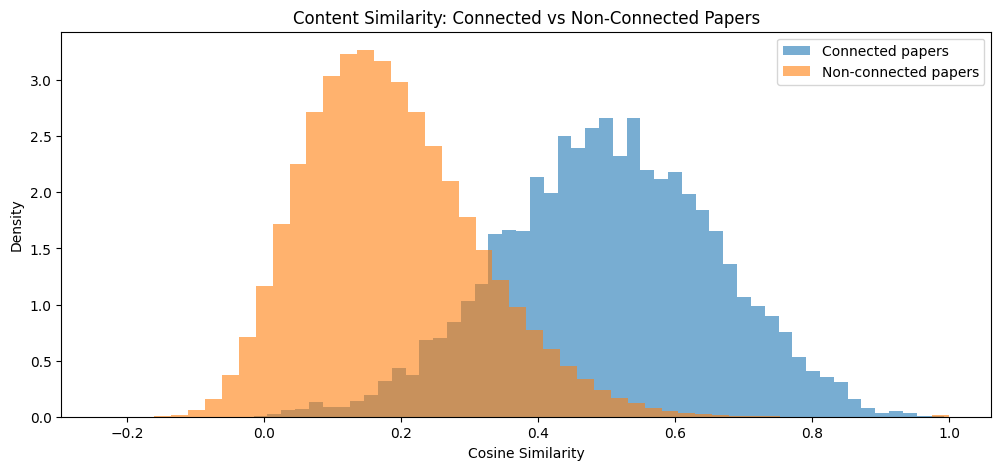

Mean similarity (connected): 0.503
Mean similarity (non-connected): 0.186


In [ ]:
from torch_geometric.utils import to_dense_adj
normalized_embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)

# -- create adjacency matrix
adj_matrix = to_dense_adj(data.edge_index)[0]

# -- compute cosine similarity matrix
similarity_matrix = normalized_embeddings @ normalized_embeddings.T

# -- extract similarities for connected and non-connected pairs
connected_pairs = adj_matrix.nonzero(as_tuple=True)
non_connected_pairs = (1 - adj_matrix).nonzero(as_tuple=True)
connected_similarities = similarity_matrix[connected_pairs].cpu().numpy()
non_connected_similarities = similarity_matrix[non_connected_pairs].cpu().numpy()

plt.figure(figsize=(12, 5))
plt.hist(connected_similarities, bins=50, alpha=0.6, label='Connected papers', density=True)
plt.hist(non_connected_similarities, bins=50, alpha=0.6, label='Non-connected papers', density=True)
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.title('Content Similarity: Connected vs Non-Connected Papers')
plt.legend()
plt.show()

print(f"Mean similarity (connected): {connected_similarities.mean():.3f}")
print(f"Mean similarity (non-connected): {non_connected_similarities.mean():.3f}")

We can observe that the connected papers tend to have higher content similarity compared to non-connected papers. This suggests that the graph structure is indeed capturing some aspects of the content similarity between papers. There is also some overlap between the two distributions, we interpret this by the fact that co-cited papers may not always be similar in content, as they could be cited together for other reasons like methodoloy, dataset, etc.

## 3.2 Node Represetations

In [6]:
# -- load data and embeddings
import torch
data = torch.load("data/cora.pt", weights_only=False)
embeddings = torch.load("data/cora_embeddings.pt", weights_only=True)

data.x = embeddings

### 3.2.1 Splitting edges into train/val/test
Our graph is undirected, so each edge (u, v) is bidirectional. When splitting the edges into train/val/test sets, we need to make sure that both directions of an edge are in the same set. For example, if (u, v) is in the training set, then (v, u) should also be in the training set. This is important to avoid data leakage during training and evaluation.

In [17]:
from torch_geometric.transforms import RandomLinkSplit


# -- split edges: 80% train, 10% validation, 10% test
transform = RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    is_undirected=True, # to avoid leakage
    add_negative_train_samples=True,  # generate negative examples for training
    neg_sampling_ratio=1.0,  # to have a balanced train set
    split_labels=True,  # to split pos_edge_label and neg_edge_label tensors
)

train_data, val_data, test_data = transform(data)

In [48]:
print("Split Results:")
print("="*60)
print(f"Training set:")
print(f"  Number of nodes: {train_data.num_nodes}")
print(f"  Number of edges (Message passing): {train_data.num_edges}")
print(f"  Number of positive training edges: {train_data.pos_edge_label_index.shape[1]}")
print(f"  Number of negative training edges: {train_data.neg_edge_label_index.shape[1]}")
print(f"  Split ratio: {100*train_data.edge_index.shape[1] / data.edge_index.shape[1]:.1f}%")
print("="*60)
print(f"Validation set:")
print(f"  Number of nodes: {val_data.num_nodes}")
print(f"  Number of edges (Message passing): {val_data.num_edges}")
print(f"  Number of positive validation edges: {val_data.pos_edge_label_index.shape[1]}")
print(f"  Split ratio: {100*2*val_data.pos_edge_label_index.shape[1] / data.edge_index.shape[1]:.1f}%")
print("="*60)
print(f"Test set:")
print(f"  Number of nodes: {test_data.num_nodes}")
print(f"  Number of edges (Message passing): {test_data.num_edges}")
print(f"  Number of positive test edges: {test_data.pos_edge_label_index.shape[1]}")
print(f"  Split ratio: {100*2*test_data.pos_edge_label_index.shape[1] / data.edge_index.shape[1]:.1f}%")
print("="*60)

Split Results:
Training set:
  Number of nodes: 2708
  Number of edges (Message passing): 8690
  Number of positive training edges: 4345
  Number of negative training edges: 4345
  Split ratio: 80.0%
Validation set:
  Number of nodes: 2708
  Number of edges (Message passing): 8690
  Number of positive validation edges: 542
  Split ratio: 10.0%
Test set:
  Number of nodes: 2708
  Number of edges (Message passing): 9774
  Number of positive test edges: 542
  Split ratio: 10.0%


We got almost perfect splits with 80% of edges for training, 10% for validation, and 10% for testing.<br>

Note that the number of edges used for message passing during training is different from the number of edges (positive edges) used for supervision (predicting the presence of an edge). This is normal behavior because message passing edges will be used to model the graph structure (in Aggregation for example) so we need both directions of edges to identify neighbours. While supervision edges will be considered unidirectional for binary classification.<br>

Validation message passing edges are the same as training edges because we can't use validation edges (that we want to predict) during message passing.<br>

Test message passing edges include both training and validation edges because the latter are known during testing (we want to predict test edges only).

### 3.2.2 Method 1 : Neighbor Aggregation

In [57]:
import torch.nn.functional as F
from torch_geometric.utils import to_dense_adj

def neighbor_aggregation(x, edge_index, num_hops=2, split_name=""):
    """
    Aggregate neighbor features via multi-hop message passing
    
    Args:
        x: Node features [num_nodes, feature_dim]
        edge_index: Graph edges [2, num_edges]
        num_hops: Number of hops for aggregation
    
    Returns:
        Aggregated embeddings [num_nodes, feature_dim]
    """
    adj = to_dense_adj(edge_index)[0]
    
    # -- we add self-loops (so node keeps its own information)
    adj = adj + torch.eye(adj.shape[0], device=adj.device)
    
    # -- normalize by degree (row normalization)
    degree = adj.sum(dim=1)
    adj_norm = adj / degree.unsqueeze(1)
    
    h = x.clone()
    for hop in range(num_hops):
        h = torch.mm(adj_norm, h)

    print(f"{split_name} embeddings shape: {h.shape}")

    return h

NUM_HOPS = 2
print("="*60)
print(f"   COMPUTING NEIGHBOR AGGREGATION EMBEDDINGS (NUM_HOPS={NUM_HOPS})")
print("="*60)

train_emb_agg = neighbor_aggregation(
    train_data.x,
    train_data.edge_index,
    num_hops=NUM_HOPS,
    split_name="Train"
)

val_emb_agg = neighbor_aggregation(
    val_data.x,
    val_data.edge_index,
    num_hops=NUM_HOPS,
    split_name="Validation"
)

test_emb_agg = neighbor_aggregation(
    test_data.x,
    test_data.edge_index,
    num_hops=NUM_HOPS,
    split_name="Test"
)


   COMPUTING NEIGHBOR AGGREGATION EMBEDDINGS (NUM_HOPS=2)
Train embeddings shape: torch.Size([2708, 1024])
Validation embeddings shape: torch.Size([2708, 1024])
Test embeddings shape: torch.Size([2708, 1024])


### 3.2.2.1 Neighbor Aggregation with Dot Product Scoring
In this method, we use the aggregated embeddings directly to predict the presence of an edge between two nodes using the dot product as a scoring function. We hope that the aggregation captured enough information about the structure of the graph to make accurate predictions.


In [96]:
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np
import pandas as pd

def predict_edges(embeddings, edge_label_index):
    """
    Predict edge existence using dot product
    
    Args:
        embeddings: Node embeddings [num_nodes, embedding_dim]
        edge_label_index: Edge pairs to predict [2, pos/neg_edge_index]

    Returns:
        Scores for each edge [pos/neg_edge_index]
    """
    src = edge_label_index[0]
    dst = edge_label_index[1]

    src_emb = embeddings[src]
    dst_emb = embeddings[dst]

    # dot product (cosine similarity for normalized embeddings)
    scores = (src_emb * dst_emb).sum(dim=-1)
    
    return scores

def evaluate(embeddings, pos_edge_index, neg_edge_index, split_name=""):
    """
    Evaluate link prediction performance
    
    Args:
        embeddings: Node embeddings [num_nodes, embedding_dim]
        pos_edge_index: Positive edge pairs [2, num_pos_edges]
        neg_edge_index: Negative edge pairs [2, num_neg_edges]
        split_name: Name for printing
    
    Returns:
        Dictionary with metrics
    """
    # -- predict positive and negative edge scores
    pos_scores = predict_edges(embeddings, pos_edge_index)
    neg_scores = predict_edges(embeddings, neg_edge_index)
    
    # -- combine scores and create labels
    scores = torch.cat([pos_scores, neg_scores]).cpu().numpy()
    labels = np.concatenate([
        np.ones(pos_scores.shape[0]),   # 1 for positive edges
        np.zeros(neg_scores.shape[0])   # 0 for negative edges
    ])
    
    # -- metrics
    auc_roc = roc_auc_score(labels, scores)
    ap = average_precision_score(labels, scores)
    
    # -- binary predictions (threshold at 0)
    preds = (scores > 0.28).astype(int)
    accuracy = (preds == labels).mean()

    # -- separate positive and negative scores for analysis
    pos_scores_np = pos_scores.cpu().numpy()
    neg_scores_np = neg_scores.cpu().numpy()
    
    # Print results
    print(f"\n{split_name} Results:")
    print(f"  ROC-AUC: {auc_roc:.4f}")
    print(f"  Average Precision: {ap:.4f}")
    print(f"  Accuracy (threshold=0.28): {accuracy:.4f}")
    print(f"  Pos edges - Mean: {pos_scores_np.mean():.4f}, Std: {pos_scores_np.std():.4f}")
    print(f"  Neg edges - Mean: {neg_scores_np.mean():.4f}, Std: {neg_scores_np.std():.4f}")
    print(f"  Separation: {pos_scores_np.mean() - neg_scores_np.mean():.4f}")
    
    return {
        'roc_auc': auc_roc,
        'ap': ap,
        'accuracy': accuracy,
        'pos_mean': pos_scores_np.mean(),
        'neg_mean': neg_scores_np.mean(),
    }




Mean difference (pos - neg) on train set: 0.2840


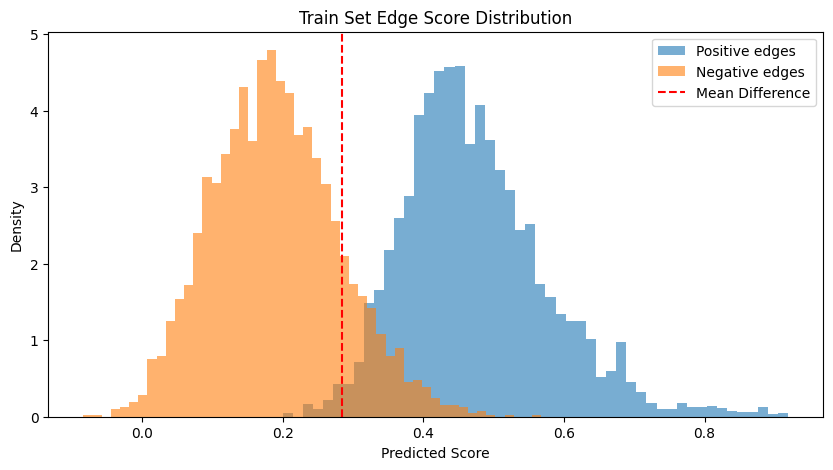

In [95]:
# -- choose the right threshold based on train set scores
import matplotlib.pyplot as plt
train_pos_scores = predict_edges(train_emb_agg, train_data.pos_edge_label_index)
train_neg_scores = predict_edges(train_emb_agg, train_data.neg_edge_label_index)

mean_difference = train_pos_scores.mean() - train_neg_scores.mean()
print(f"\nMean difference (pos - neg) on train set: {mean_difference:.4f}")

# -- visualize score distributions to choose threshold (mean difference)
plt.figure(figsize=(10, 5))
plt.hist(train_pos_scores.cpu().numpy(), bins=50, alpha=0.6, label='Positive edges', density=True)
plt.hist(train_neg_scores.cpu().numpy(), bins=50, alpha=0.6, label='Negative edges', density=True)
plt.axvline(x=mean_difference, color='r', linestyle='--', label='Mean Difference')
plt.xlabel('Predicted Score')
plt.ylabel('Density')
plt.title('Train Set Edge Score Distribution')
plt.legend()
plt.show()

In [97]:
print("\n" + "=" * 70)
print("EVALUATION")
print("=" * 70)

# Training set
train_results = evaluate(
    train_emb_agg,
    train_data.pos_edge_label_index,
    train_data.neg_edge_label_index,
    split_name="TRAINING SET"
)

# Validation set
val_results = evaluate(
    val_emb_agg,
    val_data.pos_edge_label_index,
    val_data.neg_edge_label_index,
    split_name="VALIDATION SET"
)

# Test set
test_results = evaluate(
    test_emb_agg,
    test_data.pos_edge_label_index,
    test_data.neg_edge_label_index,
    split_name="TEST SET"
)

results_df = pd.DataFrame({
    'Split': ['Train', 'Validation', 'Test'],
    'ROC-AUC': [train_results['roc_auc'], val_results['roc_auc'], test_results['roc_auc']],
    'AP': [train_results['ap'], val_results['ap'], test_results['ap']],
    'Accuracy': [train_results['accuracy'], val_results['accuracy'], test_results['accuracy']],
})

print("\n" + "=" * 70)
print("RESULTS SUMMARY")
print("=" * 70)
print(results_df)

results_df.to_csv("results/neighbor_aggregation_results.csv", index=False)


EVALUATION

TRAINING SET Results:
  ROC-AUC: 0.9851
  Average Precision: 0.9838
  Accuracy (threshold=0.28): 0.9161
  Pos edges - Mean: 0.4740, Std: 0.1036
  Neg edges - Mean: 0.1900, Std: 0.0899
  Separation: 0.2840

VALIDATION SET Results:
  ROC-AUC: 0.9497
  Average Precision: 0.9440
  Accuracy (threshold=0.28): 0.8782
  Pos edges - Mean: 0.4220, Std: 0.1082
  Neg edges - Mean: 0.1948, Std: 0.0930
  Separation: 0.2272

TEST SET Results:
  ROC-AUC: 0.9645
  Average Precision: 0.9622
  Accuracy (threshold=0.28): 0.8994
  Pos edges - Mean: 0.4226, Std: 0.0996
  Neg edges - Mean: 0.1847, Std: 0.0889
  Separation: 0.2380

RESULTS SUMMARY
        Split   ROC-AUC        AP  Accuracy
0       Train  0.985086  0.983769  0.916110
1  Validation  0.949653  0.944025  0.878229
2        Test  0.964461  0.962203  0.899446


### 3.2.2.2 Neighbor Aggregation with Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch


def create_edge_dataset(embeddings, pos_edge_index, neg_edge_index):
    """
    Create tabular dataset by concatenating node embeddings for each edge
    
    Args:
        embeddings: Node embeddings [num_nodes, embedding_dim]
        pos_edge_index: Positive edges [2, num_pos]
        neg_edge_index: Negative edges [2, num_neg]
    
    Returns:
        X: Feature matrix [num_edges, 2*embedding_dim]
        y: Labels [num_edges] (1 for positive, 0 for negative)
    """
    pos_src = pos_edge_index[0].cpu().numpy()
    pos_dst = pos_edge_index[1].cpu().numpy()

    neg_src = neg_edge_index[0].cpu().numpy()
    neg_dst = neg_edge_index[1].cpu().numpy()

    emb_np = embeddings.cpu().numpy() 
    
    pos_features = np.concatenate([
        emb_np[pos_src],
        emb_np[pos_dst]
    ], axis=1)
    
    neg_features = np.concatenate([
        emb_np[neg_src],
        emb_np[neg_dst]
    ], axis=1)
    
    X = np.vstack([pos_features, neg_features])
    y = np.hstack([
        np.ones(len(pos_src)),   # 1 for positive
        np.zeros(len(neg_src))   # 0 for negative
    ])
    
    return X, y


print("=" * 70)
print("CREATING TABULAR DATASETS FOR LOGISTIC REGRESSION")
print("=" * 70)

# Training set
X_train, y_train = create_edge_dataset(
    train_emb_agg,
    train_data.pos_edge_label_index,
    train_data.neg_edge_label_index
)

# Validation set
X_val, y_val = create_edge_dataset(
    val_emb_agg,
    val_data.pos_edge_label_index,
    val_data.neg_edge_label_index
)

# Test set
X_test, y_test = create_edge_dataset(
    test_emb_agg,
    test_data.pos_edge_label_index,
    test_data.neg_edge_label_index
)

print(f"\nDataset shapes:")
print(f"  Train: X={X_train.shape}, y={y_train.shape}")
print(f"  Val:   X={X_val.shape}, y={y_val.shape}")
print(f"  Test:  X={X_test.shape}, y={y_test.shape}")
print(f"  Feature dimension: {X_train.shape[1]} (2 × {X_train.shape[1]//2})")

CREATING TABULAR DATASETS FOR LOGISTIC REGRESSION

Dataset shapes:
  Train: X=(8690, 2048), y=(8690,)
  Val:   X=(1084, 2048), y=(1084,)
  Test:  X=(1084, 2048), y=(1084,)
  Feature dimension: 2048 (2 × 1024)


In [101]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


print("\n" + "=" * 70)
print("TRAINING LOGISTIC REGRESSION")
print("=" * 70)

lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    solver='lbfgs',  
)

lr_model.fit(X_train_scaled, y_train)



TRAINING LOGISTIC REGRESSION


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multi

In [104]:
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, classification_report

def evaluate_lr(model, X, y, scaler, split_name=""):
    """Evaluate logistic regression model"""
    y_pred_proba = model.predict_proba(X)[:, 1]  
    y_pred = model.predict(X)
    
    auc = roc_auc_score(y, y_pred_proba)
    ap = average_precision_score(y, y_pred_proba)
    acc = accuracy_score(y, y_pred)
    
    print(f"\n{split_name} Results:")
    print(f"  ROC-AUC: {auc:.4f}")
    print(f"  AP: {ap:.4f}")
    print(f"  Accuracy: {acc:.4f}")
    print(f"\n{split_name} Classification Report:")
    print(classification_report(y, y_pred, target_names=['No Edge', 'Edge']))
    
    return {
        'roc_auc': auc,
        'ap': ap,
        'accuracy': acc,
        'y_pred_proba': y_pred_proba,
        'y_pred': y_pred
    }

print("\n" + "=" * 70)
print("EVALUATION")
print("=" * 70)

train_lr_results = evaluate_lr(lr_model, X_train_scaled, y_train, scaler, "TRAINING SET")
val_lr_results = evaluate_lr(lr_model, X_val_scaled, y_val, scaler, "VALIDATION SET")
test_lr_results = evaluate_lr(lr_model, X_test_scaled, y_test, scaler, "TEST SET")

results_lr_df = pd.DataFrame({
    'Split': ['Train', 'Validation', 'Test'],
    'ROC-AUC': [train_lr_results['roc_auc'], val_lr_results['roc_auc'], test_lr_results['roc_auc']],
    'AP': [train_lr_results['ap'], val_lr_results['ap'], test_lr_results['ap']],
    'Accuracy': [train_lr_results['accuracy'], val_lr_results['accuracy'], test_lr_results['accuracy']],
})

print("\n" + "=" * 70)
print("RESULTS SUMMARY")
print("=" * 70)
print(results_lr_df)

results_lr_df.to_csv("results/logistic_regression_results.csv", index=False)



EVALUATION

TRAINING SET Results:
  ROC-AUC: 0.8341
  AP: 0.8161
  Accuracy: 0.7596

TRAINING SET Classification Report:
              precision    recall  f1-score   support

     No Edge       0.77      0.74      0.75      4345
        Edge       0.75      0.78      0.76      4345

    accuracy                           0.76      8690
   macro avg       0.76      0.76      0.76      8690
weighted avg       0.76      0.76      0.76      8690


VALIDATION SET Results:
  ROC-AUC: 0.5825
  AP: 0.5884
  Accuracy: 0.5646

VALIDATION SET Classification Report:
              precision    recall  f1-score   support

     No Edge       0.57      0.53      0.55       542
        Edge       0.56      0.60      0.58       542

    accuracy                           0.56      1084
   macro avg       0.56      0.56      0.56      1084
weighted avg       0.56      0.56      0.56      1084


TEST SET Results:
  ROC-AUC: 0.6434
  AP: 0.6342
  Accuracy: 0.6208

TEST SET Classification Report:
        

### 3.2.3 Method 2 : Node2Vec + Text Embeddings

### 3.2.4 Method 3 : Graphe Convolutional Network (GCN)